In [1]:
import os
os.chdir('..')

import nmrglue as ng
import numpy as np
from cops_analysis import cops_analyze
from cops_prediction import gaussian
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralBiclustering

In [14]:
b = cops_analyze(['../no_pyruvate/GB1_BCG1.ucsf','../no_pyruvate/GB1_BCG3.ucsf','../no_pyruvate/GB1_BCG5.ucsf','../no_pyruvate/GB1_BCG6.ucsf'], mode='HCA',pyruvate_on=False, cop_num=[1,3,4,5])
tb_nopyr=pd.read_fwf('../no_pyruvate/GB1_BCG1.list', infer_nrows=300)
tb_nopyr = tb_nopyr.rename(columns={'w1':'CA','w2':'HN'})

#realign spectra
tb_nopyr = tb_nopyr.set_index(tb_nopyr['Assignment'])
tb_nopyr['is_sequential']=np.append([False], [len(tb_nopyr['Assignment'][i+1]) > len(tb_nopyr['Assignment'][i]) for i in range(len(tb_nopyr)-1)])
#tb_nopyr.loc[tb_nopyr['is_sequential'],'CA']=tb_nopyr[~tb_nopyr['is_sequential']][['CA']][:-1].to_numpy() #enforce the same CA

shifts_array = tb_nopyr[['CA', 'HN']].to_numpy(dtype=np.float32)

dslice_cop_nopyr = np.array([np.array([b.extract1D(shifts_array[j], b.cop_dats[i], b.cop_unit_convs[i],sw=90, normalize=True)[1] for i in range(len(b.copnames))]).reshape(-1) for j in range(len(shifts_array))])
dslice_cop_nopyr.shape 

(109, 156)

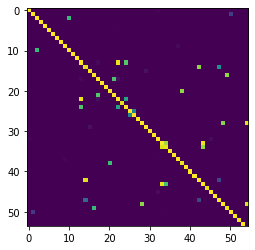

In [3]:
CAs = tb_nopyr['CA'].to_numpy()
CAs_seq = CAs[tb_nopyr['is_sequential']]
CAs_int = CAs[~tb_nopyr['is_sequential']]
CA_diff = CAs_seq.reshape(-1, 1) - CAs_int.reshape(1,-1)
CAs_likelihood = gaussian(CA_diff, 0,0.05)
plt.imshow(CAs_likelihood)


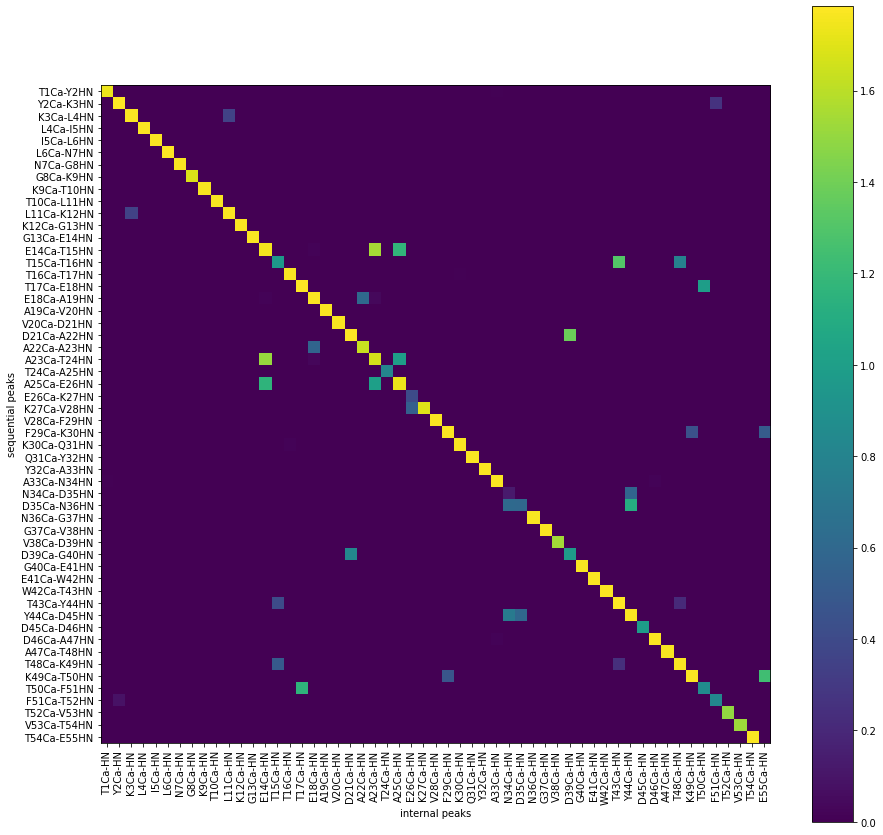

In [5]:
threshold=0
data = dslice_cop_nopyr
tb_sequential = tb_nopyr[tb_nopyr['is_sequential']]
tb_internal = tb_nopyr[~tb_nopyr['is_sequential']]
data_sequential = data[tb_nopyr['is_sequential']]
data_internal = data[~tb_nopyr['is_sequential']]
T = np.corrcoef(data_internal, data_sequential)[len(data_internal):,0:len(data_internal)]
T=np.multiply(T, CAs_likelihood)
T[T<threshold] = threshold
T=T-threshold
plt.figure(figsize=[15,15])
plt.imshow(T)
plt.xticks(np.arange(55), tb_nopyr[~tb_nopyr['is_sequential']]['Assignment'], rotation='vertical')
plt.xlabel('internal peaks')
plt.yticks(np.arange(54), tb_nopyr[tb_nopyr['is_sequential']]['Assignment'], rotation='horizontal')
plt.ylabel('sequential peaks')
plt.colorbar()
plt.show()

In [37]:
num_best = 3
index_bestmatch = np.argsort(-T, axis = 0)
index_bestmatch_toplots = index_bestmatch[0:num_best]
#[T[index_bestmatch[0,i],i] for i in range(T.shape[1])]

In [57]:
hz,_ = b.extract1D(shifts_array[0], b.cop_dats[2], b.cop_unit_convs[2], sw=150, normalize=True)
hz_long = np.array([hz+400*i for i in range(len(b.copnames))]).reshape(-1)

dslice_cop_nopyr = np.array([np.array([b.extract1D(shifts_array[j], b.cop_dats[i], b.cop_unit_convs[i],sw=150, normalize=True)[1] for i in range(len(b.copnames))]).reshape(-1) for j in range(len(shifts_array))])
data = dslice_cop_nopyr
tb_sequential = tb_nopyr[tb_nopyr['is_sequential']]
tb_internal = tb_nopyr[~tb_nopyr['is_sequential']]
data_sequential = data[tb_nopyr['is_sequential']]
data_internal = data[~tb_nopyr['is_sequential']]

cmap = ['b','r','m','y']

plt.figure(figsize=(15,5))
for j in range(len(data_internal)):
    for k in range(len(b.copnames)):
        if k ==0:
            plt.plot(hz+400*k, data_internal[j][0+len(hz)*k:len(hz)*(k+1)],'k', label = tb_internal.index[j])
        else:
            plt.plot(hz+400*k, data_internal[j][0+len(hz)*k:len(hz)*(k+1)],'k')
    for i in range(num_best):
        for k in range(len(b.copnames)):
            if k==0:
                plt.plot(hz+400*k, data_sequential[index_bestmatch[i,j]][0+len(hz)*k:len(hz)*(k+1)]-3*i,cmap[i],label = tb_sequential.index[index_bestmatch[i,j]])
            else:
                plt.plot(hz+400*k, data_sequential[index_bestmatch[i,j]][0+len(hz)*k:len(hz)*(k+1)]-3*i,cmap[i])

    plt.legend()
    plt.savefig("./dev/GB1_corr_plots/%s.png" %(tb_internal.index[j]))
    plt.clf()

<Figure size 1080x360 with 0 Axes>

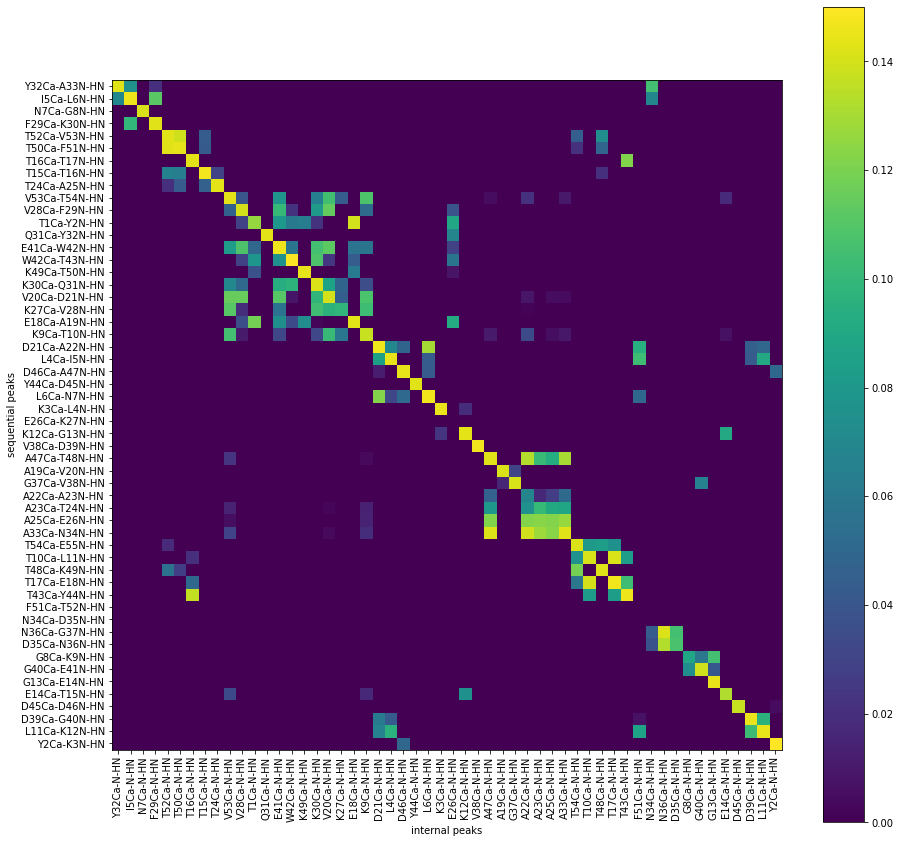

In [ ]:
model = SpectralBiclustering(n_clusters=10)
T = np.corrcoef(data_internal, data_sequential)[len(data_internal):,0:len(data_internal)]
model.fit(T+0.0001)

fit_T = T[np.argsort(model.row_labels_)]
fit_T = fit_T[:,np.argsort(model.row_labels_)]
fit_T[fit_T<threshold] = threshold
fit_T=fit_T-threshold

plt.figure(figsize=[15,15])
plt.imshow(fit_T)

internal_labels = tb[~tb['is_sequential']]['Assignment']
sequential_labels = tb[tb['is_sequential']]['Assignment']

plt.xticks(np.arange(54), internal_labels.to_numpy()[np.argsort(model.row_labels_)], rotation='vertical')
plt.xlabel('internal peaks')
plt.yticks(np.arange(54), sequential_labels.to_numpy()[np.argsort(model.row_labels_)], rotation='horizontal')
plt.ylabel('sequential peaks')
plt.colorbar()
plt.show()

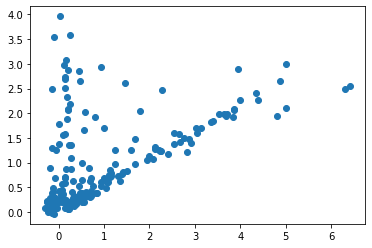

In [164]:
plt.scatter(data_internal[50], data_sequential[50])

[54.169 10.333]


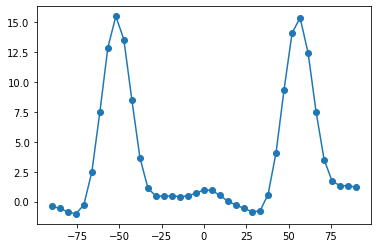

In [15]:
data = shifts_array[100] #18 for K27, #-4 for K49
print(shifts_array[100])
hz, nocop_trace = b.extract1D(data, b.cop_dats[0], b.cop_unit_convs[0], sw=90, C_offset=-0.09, normalize=True)
plt.plot(hz, nocop_trace, '-o')

[24.75800879  0.999      39.06274707  2.14537545 52.94804292  8.71180604]


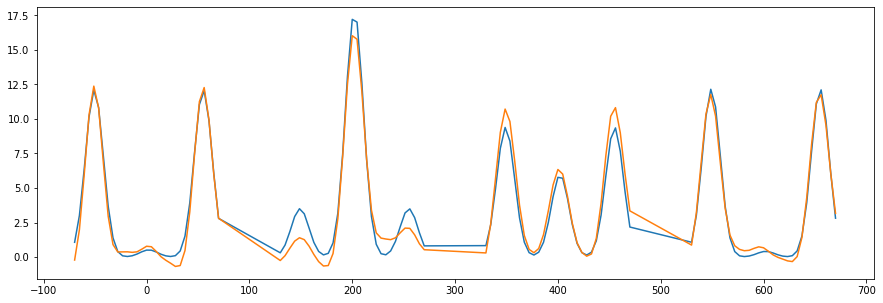

In [19]:
params,_ = b.CalcCB(data, simple_output=False)

hz, nocop_trace = b.extract1D(data, b.cop_dats[1], b.cop_unit_convs[1], normalize=True)
cop_1Ds = np.array([b.extract1D(data, b.cop_dats[i], b.cop_unit_convs[i], normalize=True)[1] for i in range(b.cop_num)])
cop_1Ds = cop_1Ds.reshape(-1)
hz_long = np.array([hz+200*i for i in range(b.cop_num)]).reshape(-1)
plt.figure(figsize=(15,5))
print(params)
plt.plot(hz_long, b.lineshape_Cb(hz, *params), hz_long, cop_1Ds)

In [13]:
a = cops_analyze(['./pyruvate_HNCA/HNCA_nocop.ft3','./pyruvate_HNCA/HNCA_cop1.ft3','./pyruvate_HNCA/HNCA_cop3.ft3','./pyruvate_HNCA/HNCA_cop4.ft3','./pyruvate_HNCA/HNCA_cop5.ft3','./pyruvate_HNCA/HNCA_cop6.ft3'], mode='HNCA',pyruvate_on=True)

KeyboardInterrupt: 

In [6]:
tb=pd.read_fwf('./files/GB1_new.shifts', infer_nrows=300)
tb = tb.drop(index=[0,1,2,3,4,5])
tb = tb.rename(columns={'w1':'CA','w2':'N','w3':'HN'})
tb.index = range(len(tb))
tb['is_sequential']=np.append([False], [len(tb['Assignment'][i+1]) > len(tb['Assignment'][i]) for i in range(len(tb)-1)])
#tb.loc[tb['is_sequential'],'CA']=tb[~tb['is_sequential']][['CA']][:-1].to_numpy() #enforce the same CA

#realign spectra
shifts_array = tb[['CA', 'N','HN']].to_numpy(dtype=np.float32)
shifts_array[:,[0,1]]=shifts_array[:,[1,0]]

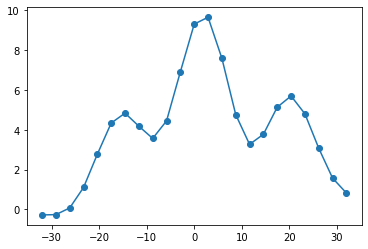

In [9]:
data = shifts_array[15] #18 for K27, #-4 for K49
hz, nocop_trace = a.extract1D(data, a.nocop_dat, a.nocop_unit_convs, sw=32, C_offset=-0.09, normalize=True)
plt.plot(hz, nocop_trace, '-o')

[51.92150879  0.51849988 39.26207884  0.84476018 16.80504476  3.12746649]


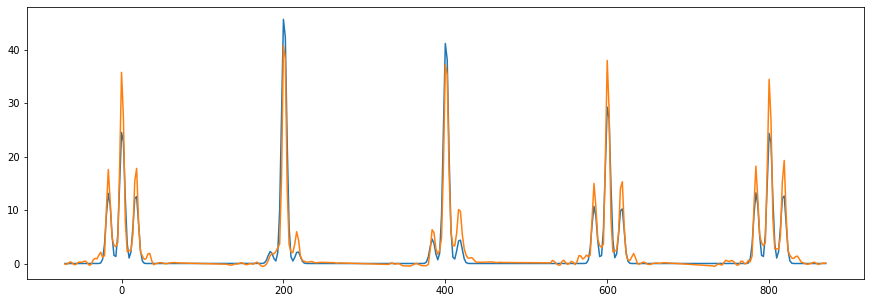

In [12]:
params,_ = a.CalcCB(data, simple_output=False)

hz, nocop_trace = a.extract1D(data, a.cop_dats[1], a.cop_unit_convs[1], normalize=True)
cop_1Ds = np.array([a.extract1D(data, a.cop_dats[i], a.cop_unit_convs[i], normalize=True)[1] for i in range(5)])
cop_1Ds = cop_1Ds.reshape(-1)
hz_long = np.array([hz+200*i for i in range(5)]).reshape(-1)
plt.figure(figsize=(15,5))
plt.plot(hz_long, a.lineshape_Cb(hz, *params), hz_long, cop_1Ds)

In [8]:
dslice_nocop = np.array([a.extract1D(shifts_array[j], a.nocop_dat, a.nocop_unit_convs,sw=32, C_offset=-0.09, normalize=True)[1] for j in range(len(shifts_array))])
dslice_nocop.shape

(109, 23)

In [9]:
dslice_cop = np.array([np.array([a.extract1D(shifts_array[j], a.cop_dats[i], a.cop_unit_convs[i],sw=32, normalize=True)[1] for i in range(5)]).reshape(-1) for j in range(len(shifts_array))])
dslice_cop.shape 

(109, 145)